In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

# to split the datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import KBinsDiscretizer

from feature_engine.discretisers import EqualFrequencyDiscretiser


### Equal Frequency Discretization

In [6]:
# load the numerical variables of the Titanic Dataset

data = pd.read_csv(
    "data/titanic.csv",
    usecols=['age', 'fare', 'survived']
)

x_train, x_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

x_train.shape, x_test.shape

((916, 2), (393, 2))

In [9]:
def impute_na(data, variable):
    # function to fill NA with a random sample

    df = data.copy()

    # random sampling
    df[variable+'_random'] = df[variable]

    # extract the random sample to fill the na
    random_sample = df[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)

    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample

    return df[variable+'_random']

In [10]:
# replace NA in both train and test sets

x_train['age'] = impute_na(data, 'age')
x_test['age'] = impute_na(data, 'age')

x_train['fare'] = impute_na(data, 'fare')
x_test['fare'] = impute_na(data, 'fare')

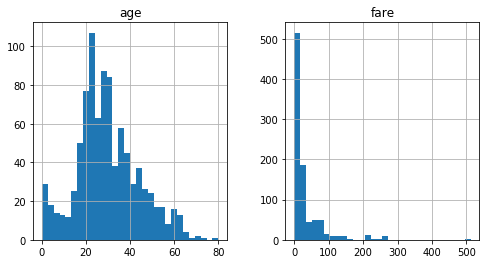

In [11]:
# let's explore the distribution of age

x_train[['age', 'fare']].hist(bins=30, figsize=(8,4))
plt.show()

#### Equal Frequency discretization with Pandas and Numpy

In [16]:
age_discretised, intervals = pd.qcut(
    x_train["age"], 
    q=10, labels=None, retbins=True, precision=3, duplicates="raise"

)

pd.concat([age_discretised, x_train["age"]], axis=1).head(5)

,age,age
501,"(0.166, 15.0]",13.0
588,"(0.166, 15.0]",4.0
402,"(28.0, 31.0]",30.0
1193,"(28.0, 31.0]",30.0
686,"(19.0, 22.0]",22.0


In [17]:
intervals

array([ 0.1667, 15.    , 19.    , 22.    , 25.    , 28.    , 31.    ,
       36.    , 41.    , 50.    , 80.    ])

In [18]:
age_discretised.value_counts()

(31.0, 36.0]     106
(22.0, 25.0]     101
(41.0, 50.0]     100
(0.166, 15.0]     98
(19.0, 22.0]      94
(25.0, 28.0]      89
(28.0, 31.0]      88
(15.0, 19.0]      86
(50.0, 80.0]      80
(36.0, 41.0]      74
Name: age, dtype: int64

In [19]:
# we can also add labels instead of having the interval boundaries, to the bins, as follows:

labels = ["Q" + str(i) for i in range(1, len(intervals))]
labels

['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10']

In [20]:
age_discretised, intervals = pd.qcut(
    x_train["age"],
    q=10,
    labels=labels,
    retbins=True,
    precision=3,
    duplicates="raise"
)
age_discretised.head()

501     Q1
588     Q1
402     Q6
1193    Q6
686     Q3
Name: age, dtype: category
Categories (10, object): [Q1 < Q2 < Q3 < Q4 ... Q7 < Q8 < Q9 < Q10]

In [21]:
# use the same to transform the test set
x_test["age_disc_label"] = pd.cut(
    x=x_test["age"],
    bins=intervals,
    labels=labels,
)
x_test["age_disc"] = pd.cut(x=x_test["age"], bins=intervals)
x_test.head(10)

,age,fare,age_disc_label,age_disc
1139,38.0,7.8958,Q8,"(36.0, 41.0]"
533,21.0,21.0000,Q3,"(19.0, 22.0]"
459,42.0,27.0000,Q9,"(41.0, 50.0]"
1150,8.0,14.5000,Q1,"(0.167, 15.0]"
393,25.0,31.5000,Q4,"(22.0, 25.0]"
1189,4.0,16.7000,Q1,"(0.167, 15.0]"
5,48.0,26.5500,Q9,"(41.0, 50.0]"
231,52.0,30.5000,Q10,"(50.0, 80.0]"
330,57.0,13.0000,Q10,"(50.0, 80.0]"
887,24.0,8.1125,Q4,"(22.0, 25.0]"


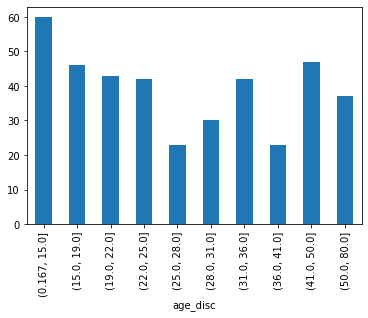

In [22]:
x_test.groupby("age_disc")["age"].count().plot.bar();

#### Equal Frequency Discretisation - FeatureEngine

In [24]:
x_train, x_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

x_train.shape, x_test.shape

x_train['age'] = impute_na(data, 'age')
x_test['age'] = impute_na(data, 'age')

x_train['fare'] = impute_na(data, 'fare')
x_test['fare'] = impute_na(data, 'fare')

In [25]:
discretiser = EqualFrequencyDiscretiser(q=10, variables=["age", "fare"])
discretiser.fit(x_train)

EqualFrequencyDiscretiser(variables=['age', 'fare'])

In [26]:
discretiser.binner_dict_

{'age': [-inf, 15.0, 19.0, 22.0, 25.0, 28.0, 31.0, 36.0, 41.0, 50.0, inf],
 'fare': [-inf,
  7.55,
  7.7958,
  8.05,
  10.5,
  14.4542,
  21.075,
  26.55,
  40.125,
  79.025,
  inf]}

In [27]:
train_t = discretiser.transform(x_train)
test_t = discretiser.transform(x_test)
train_t.head()

,age,fare
501,0,5
588,0,6
402,5,4
1193,5,1
686,2,1


Text(0, 0.5, 'Number of observations per bin')

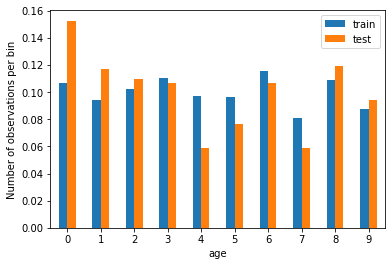

In [28]:
# and now let's explore the number of observations per bucket

t1 = train_t.groupby(['age'])['age'].count() / len(train_t)
t2 = test_t.groupby(['age'])['age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

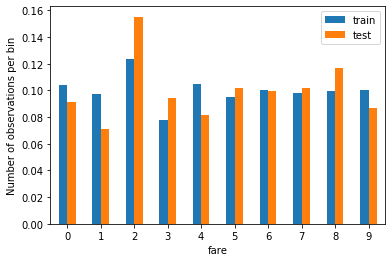

In [29]:
t1 = train_t.groupby(['fare'])['fare'].count() / len(train_t)
t2 = test_t.groupby(['fare'])['fare'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')